https://arxiv.org/pdf/1703.05334.pdf

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import print_function
import numpy as np

In [2]:
class RBM:
  
    def __init__(self, num_visible, num_hidden):
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.debug_print = True

        # Initialize a weight matrix, of dimensions (num_visible x num_hidden), using
        # a uniform distribution between -sqrt(6. / (num_hidden + num_visible))
        # and sqrt(6. / (num_hidden + num_visible)). One could vary the 
        # standard deviation by multiplying the interval with appropriate value.
        # Here we initialize the weights with mean 0 and standard deviation 0.1. 
        # Reference: Understanding the difficulty of training deep feedforward 
        # neural networks by Xavier Glorot and Yoshua Bengio
        np_rng = np.random.RandomState(1234)

        self.weights = np.asarray(np_rng.uniform(
            low=-0.1 * np.sqrt(6. / (num_hidden + num_visible)),
            high=0.1 * np.sqrt(6. / (num_hidden + num_visible)),
            size=(num_visible, num_hidden)))


        # Insert weights for the bias units into the first row and first column.
        self.weights = np.insert(self.weights, 0, 0, axis = 0)
        self.weights = np.insert(self.weights, 0, 0, axis = 1)

    def train(self, data, max_epochs = 1000, learning_rate = 0.1):
        """
        Train the machine.
        Parameters
        ----------
        data: A matrix where each row is a training example consisting of the states of visible units.    
        """

        num_examples = data.shape[0]

        # Insert bias units of 1 into the first column.
        data = np.insert(data, 0, 1, axis = 1)

        for epoch in range(max_epochs):      
            # Clamp to the data and sample from the hidden units. 
            # (This is the "positive CD phase", aka the reality phase.)
            pos_hidden_activations = np.dot(data, self.weights)      
            pos_hidden_probs = self._logistic(pos_hidden_activations)
            pos_hidden_probs[:,0] = 1 # Fix the bias unit.
            pos_hidden_states = pos_hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
#             pos_hidden_states = pos_hidden_probs

            # Note that we're using the activation *probabilities* of the hidden states, not the hidden states       
            # themselves, when computing associations. We could also use the states; see section 3 of Hinton's 
            # "A Practical Guide to Training Restricted Boltzmann Machines" for more.
            pos_associations = np.dot(data.T, pos_hidden_probs)

            # Reconstruct the visible units and sample again from the hidden units.
            # (This is the "negative CD phase", aka the daydreaming phase.)
            neg_visible_activations = np.dot(pos_hidden_states, self.weights.T)
            neg_visible_probs = self._logistic(neg_visible_activations)
            neg_visible_probs[:,0] = 1 # Fix the bias unit.
            neg_hidden_activations = np.dot(neg_visible_probs, self.weights)
            neg_hidden_probs = self._logistic(neg_hidden_activations)
            # Note, again, that we're using the activation *probabilities* when computing associations, not the states 
            # themselves.
            neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

            # Update weights.
            self.weights += learning_rate * ((pos_associations - neg_associations) / num_examples)

            error = np.sum((data - neg_visible_probs) ** 2)
            if self.debug_print:
                print("Epoch %s: error is %s" % (epoch, error))

    def run_visible(self, data):
        """
        Assuming the RBM has been trained (so that weights for the network have been learned),
        run the network on a set of visible units, to get a sample of the hidden units.

        Parameters
        ----------
        data: A matrix where each row consists of the states of the visible units.

        Returns
        -------
        hidden_states: A matrix where each row consists of the hidden units activated from the visible
        units in the data matrix passed in.
        """

        num_examples = data.shape[0]

        # Create a matrix, where each row is to be the hidden units (plus a bias unit)
        # sampled from a training example.
        hidden_states = np.ones((num_examples, self.num_hidden + 1))

        # Insert bias units of 1 into the first column of data.
        data = np.insert(data, 0, 1, axis = 1)

        # Calculate the activations of the hidden units.
        hidden_activations = np.dot(data, self.weights)
        # Calculate the probabilities of turning the hidden units on.
        hidden_probs = self._logistic(hidden_activations)
        # Turn the hidden units on with their specified probabilities.
        hidden_states[:,:] = hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
#         hidden_states[:,:] = hidden_probs

        # Ignore the bias units.
        hidden_states = hidden_states[:,1:]
        return hidden_states
    
    # TODO: Remove the code duplication between this method and `run_visible`?
    def run_hidden(self, data):
        """
        Assuming the RBM has been trained (so that weights for the network have been learned),
        run the network on a set of hidden units, to get a sample of the visible units.
        Parameters
        ----------
        data: A matrix where each row consists of the states of the hidden units.
        Returns
        -------
        visible_states: A matrix where each row consists of the visible units activated from the hidden
        units in the data matrix passed in.
        """

        num_examples = data.shape[0]

        # Create a matrix, where each row is to be the visible units (plus a bias unit)
        # sampled from a training example.
        visible_states = np.ones((num_examples, self.num_visible + 1))

        # Insert bias units of 1 into the first column of data.
        data = np.insert(data, 0, 1, axis = 1)

        # Calculate the activations of the visible units.
        visible_activations = np.dot(data, self.weights.T)
        # Calculate the probabilities of turning the visible units on.
        visible_probs = self._logistic(visible_activations)
        # Turn the visible units on with their specified probabilities.
        visible_states[:,:] = visible_probs > np.random.rand(num_examples, self.num_visible + 1)
#         visible_states[:,:] = visible_probs
        # Always fix the bias unit to 1.
        # visible_states[:,0] = 1

        # Ignore the bias units.
        visible_states = visible_states[:,1:]
        return visible_states
    
    def daydream(self, num_samples):
        """
        Randomly initialize the visible units once, and start running alternating Gibbs sampling steps
        (where each step consists of updating all the hidden units, and then updating all of the visible units),
        taking a sample of the visible units at each step.
        Note that we only initialize the network *once*, so these samples are correlated.
        Returns
        -------
        samples: A matrix, where each row is a sample of the visible units produced while the network was
        daydreaming.
        """

        # Create a matrix, where each row is to be a sample of of the visible units 
        # (with an extra bias unit), initialized to all ones.
        samples = np.ones((num_samples, self.num_visible + 1))

        # Take the first sample from a uniform distribution.
        samples[0,1:] = np.random.rand(self.num_visible)

        # Start the alternating Gibbs sampling.
        # Note that we keep the hidden units binary states, but leave the
        # visible units as real probabilities. See section 3 of Hinton's
        # "A Practical Guide to Training Restricted Boltzmann Machines"
        # for more on why.
        for i in range(1, num_samples):
            visible = samples[i-1,:]

            # Calculate the activations of the hidden units.
            hidden_activations = np.dot(visible, self.weights)      
            # Calculate the probabilities of turning the hidden units on.
            hidden_probs = self._logistic(hidden_activations)
            # Turn the hidden units on with their specified probabilities.
            hidden_states = hidden_probs > np.random.rand(self.num_hidden + 1)
#             hidden_states = hidden_probs
            # Always fix the bias unit to 1.
            hidden_states[0] = 1

            # Recalculate the probabilities that the visible units are on.
            visible_activations = np.dot(hidden_states, self.weights.T)
            visible_probs = self._logistic(visible_activations)
            visible_states = visible_probs > np.random.rand(self.num_visible + 1)
#             visible_states = visible_probs
            samples[i,:] = visible_states

        # Ignore the bias units (the first column), since they're always set to 1.
        return samples[:,1:]        
      
    def _logistic(self, x):
        return 1.0 / (1 + np.exp(-x))

In [3]:
# import itertools
# all_strings = ["".join(seq) for seq in itertools.product("01", repeat=6)]
# data = list(map(lambda bit_string: list(map(lambda x: int(x), bit_string)), all_strings))
# data

In [4]:
# data = [[0,0,0,0], [0,0,0,1], [0,0,1,0], [0,0,1,1]]
data = [[0,0,0,1], [0,0,1,0], [0,1,0,0], [1,0,0,0]] * 500

In [5]:
N = 20
data = []
for i in range(N):
    tmp = [0] * N
    tmp[i] += 1
    data.append(tmp)
data

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

In [6]:
training_data = np.array(data)

r = RBM(num_visible=N, num_hidden=N)
r.debug_print = False
r.train(training_data, max_epochs=5000, learning_rate=0.1)

In [7]:
# print(r.weights)

In [8]:
# user = np.array([[1,0,0,1]])
# print(r.run_visible(user))
# print(r.run_hidden(user))

In [9]:
# user = np.array([[0,1,0,1]])
# hid = r.run_visible(user)
# plt.plot(user[0])
# plt.plot((r.run_hidden(hid))[0])
# plt.show()

In [16]:
total_iter = 100
out = r.daydream(total_iter)[-1]
out

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [17]:
def dreaming(rbm, total_dream=1, total_iter=10):
    res = []
    for i in range(total_dream):
        res.append(rbm.daydream(total_iter)[-1])
    res = np.array(res)
    return res

In [18]:
from collections import Counter

In [19]:
dreams = dreaming(r, total_dream=1000, total_iter=10)
dreams = [tuple(x) for x in dreams]
c = Counter(dreams)
# to_plot = [(''.join([str(int(ch)) for ch in x[0]]), x[1]) for x in list(c.items())]
to_plot = [(''.join([str(int(ch)) for ch in x]), c[tuple(x)]/1000) for x in data]

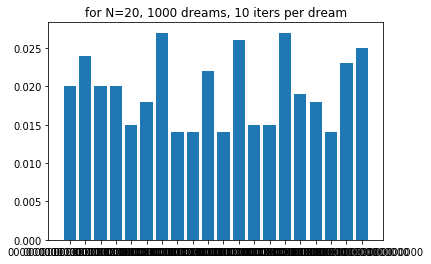

In [20]:
plt.figure()
plt.bar([x[0] for x in to_plot], [x[1] for x in to_plot])
plt.title('for N=20, 1000 dreams, 10 iters per dream')
plt.show()

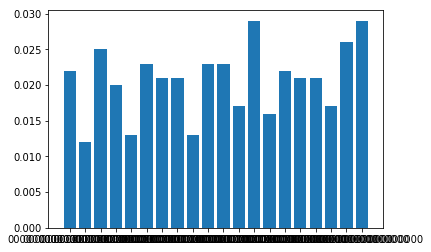

In [418]:
plt.figure()
plt.bar([x[0] for x in to_plot], [x[1] for x in to_plot])
plt.show()